### Importing Libraries

In [1]:
import os
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
# Machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Définir le chemin du dossier où enregistrer les modèles
from joblib import dump
joblib_dir = './joblib'

### Data Loading and Initial Exploration

In [2]:
# Load the dataset
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# Define the column names
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", 
           "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", 
           "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
           "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
           "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
           "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
           "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", 
           "dst_host_srv_rerror_rate", "attack", "last_flag"]

train.columns = columns
test.columns = columns

# Display the first few rows of the dataset
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

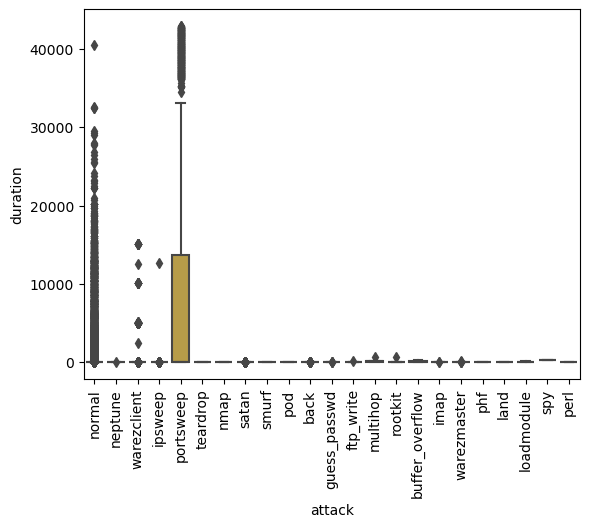

In [4]:
sns.boxplot(data=train, x="attack", y="duration")
plt.xticks(rotation=90)
plt.show()



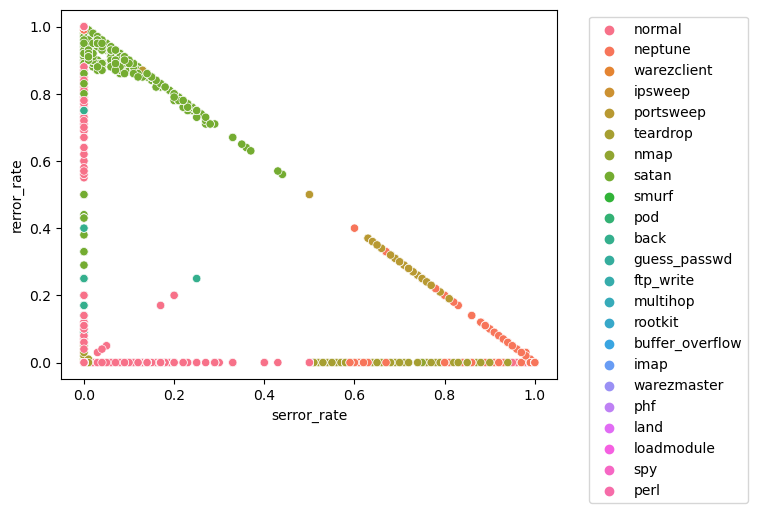

In [5]:
sns.scatterplot(data=train, x="serror_rate", y="rerror_rate", hue="attack")

# Afficher la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



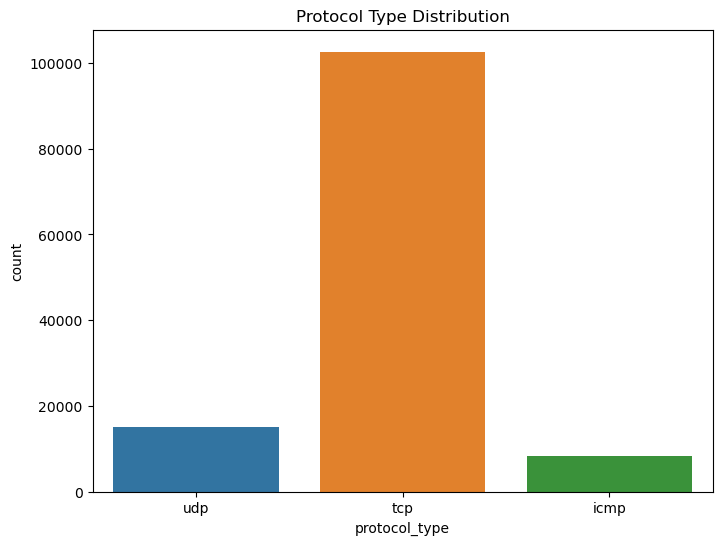

In [6]:
# Plotting Protocol Type Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='protocol_type', data=train)
plt.title('Protocol Type Distribution')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


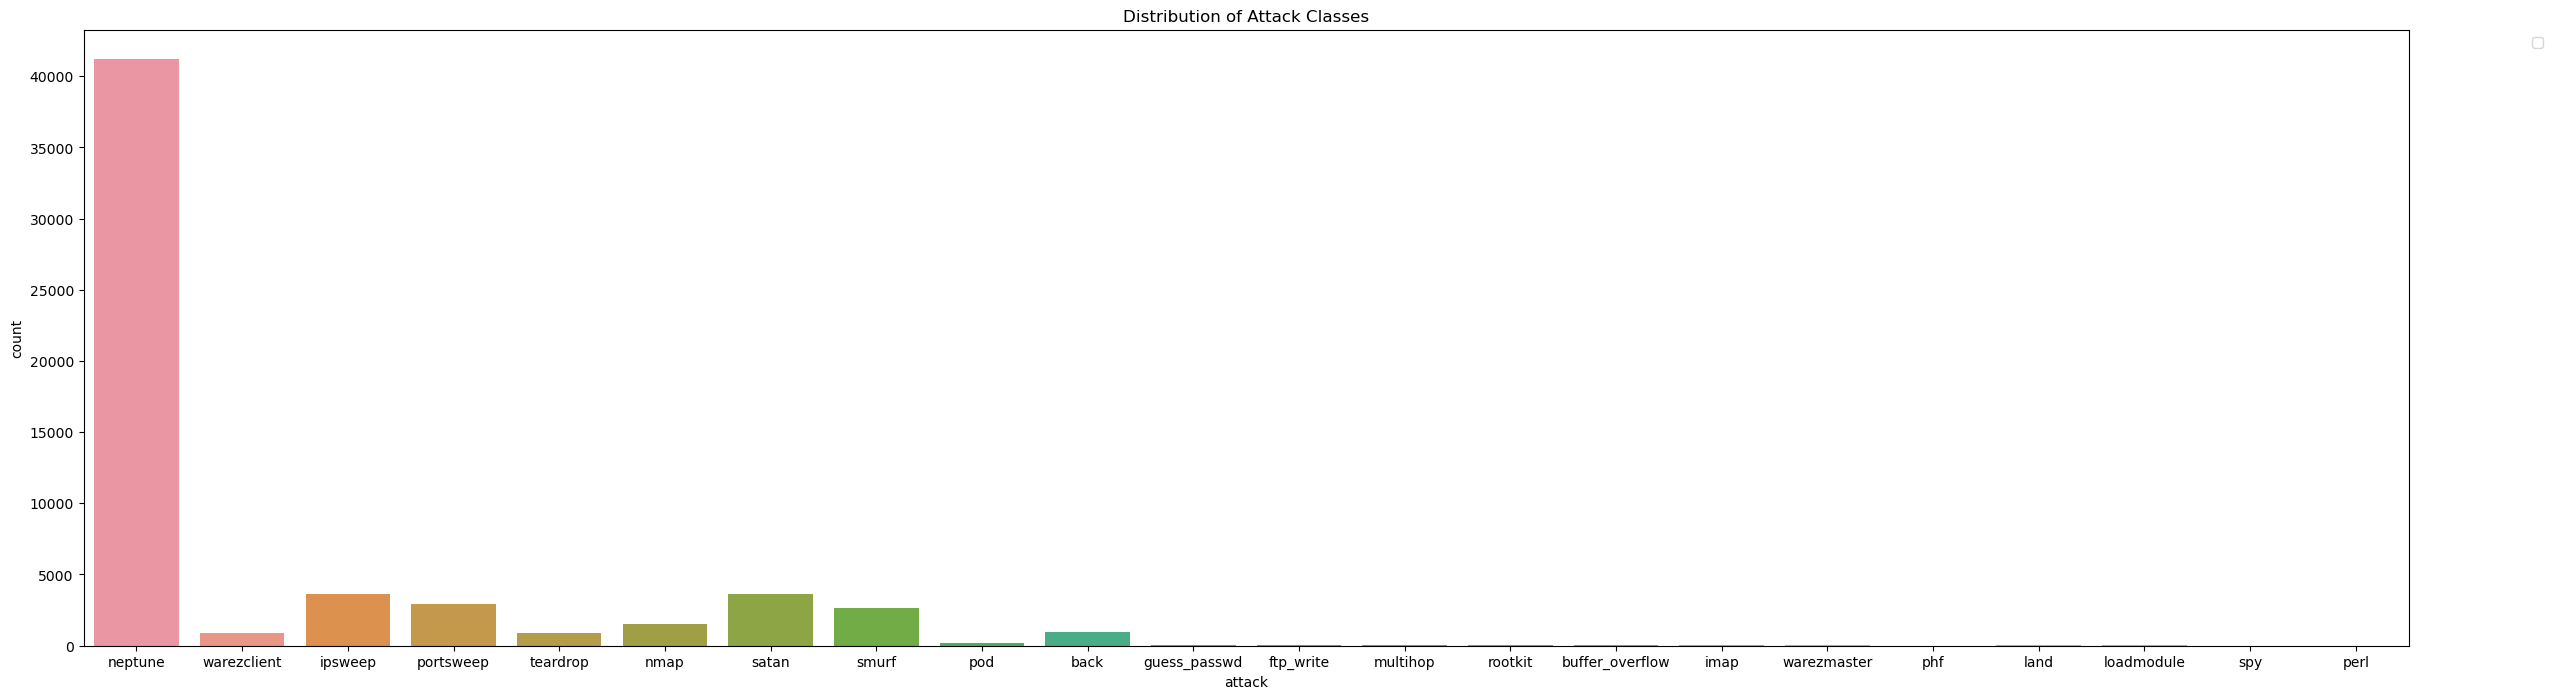

In [7]:
train_filtered = train[train['attack'] != 'normal']

# Créer le countplot avec les données filtrées
plt.figure(figsize=(30, 8))
sns.countplot(x='attack', data=train_filtered)
plt.title('Distribution of Attack Classes')

# Afficher la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

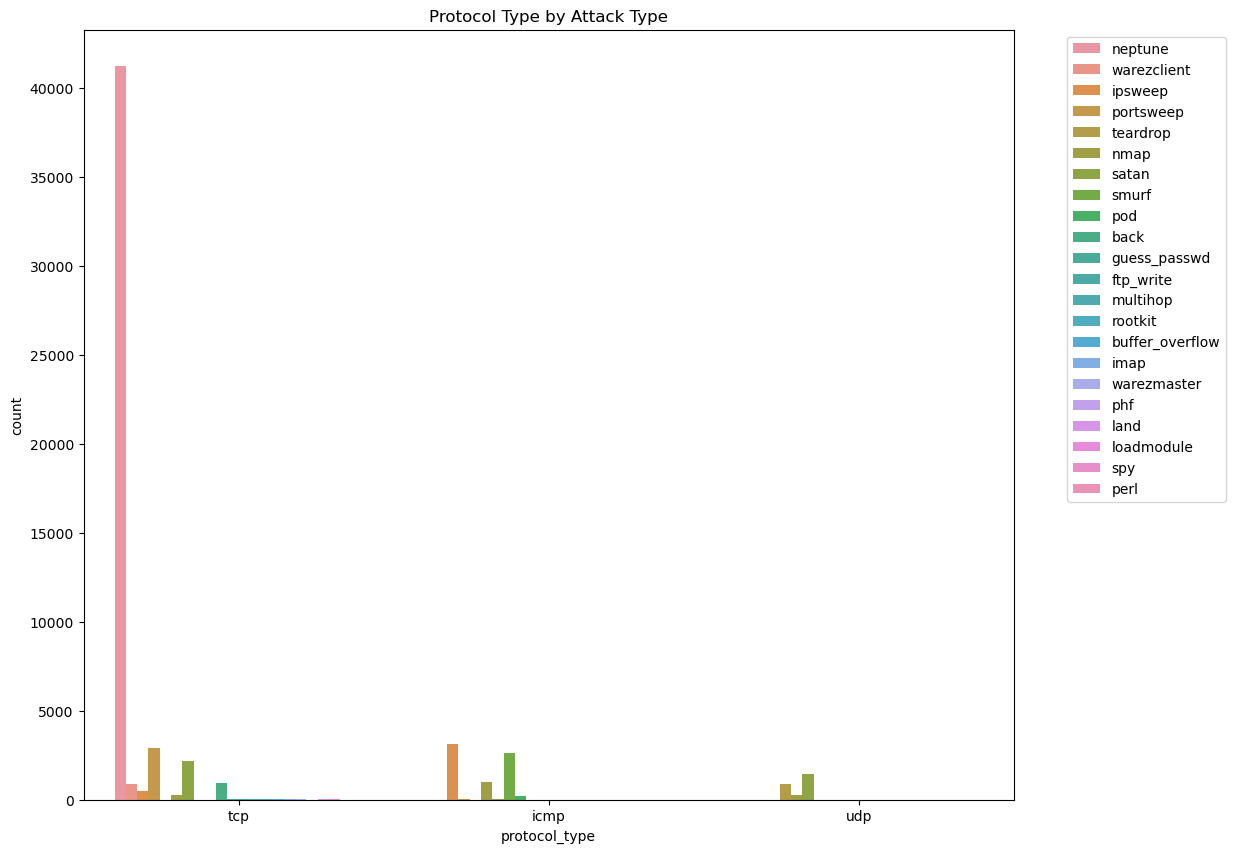

In [8]:
train_filtered = train[train['attack'] != 'normal']

# Créer le countplot avec les données filtrées
plt.figure(figsize=(12, 10))
sns.countplot(data=train_filtered, x='protocol_type', hue='attack')
plt.title('Protocol Type by Attack Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

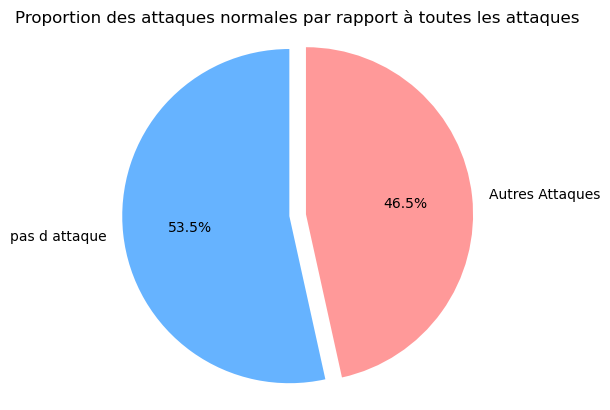

In [9]:
attack_counts = train['attack'].value_counts()

# Calculer la proportion des attaques nommées "normal" par rapport au nombre total d'attaques
normal_count = attack_counts.get('normal', 0)
total_count = attack_counts.sum()
proportion_normal = normal_count / total_count

# Créer un graphique en cercle pour représenter cette proportion
labels = ['pas d attaque', 'Autres Attaques']
sizes = [proportion_normal, 1 - proportion_normal]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode le premier secteur

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Le graphique est un cercle
plt.title('Proportion des attaques normales par rapport à toutes les attaques')
plt.show()

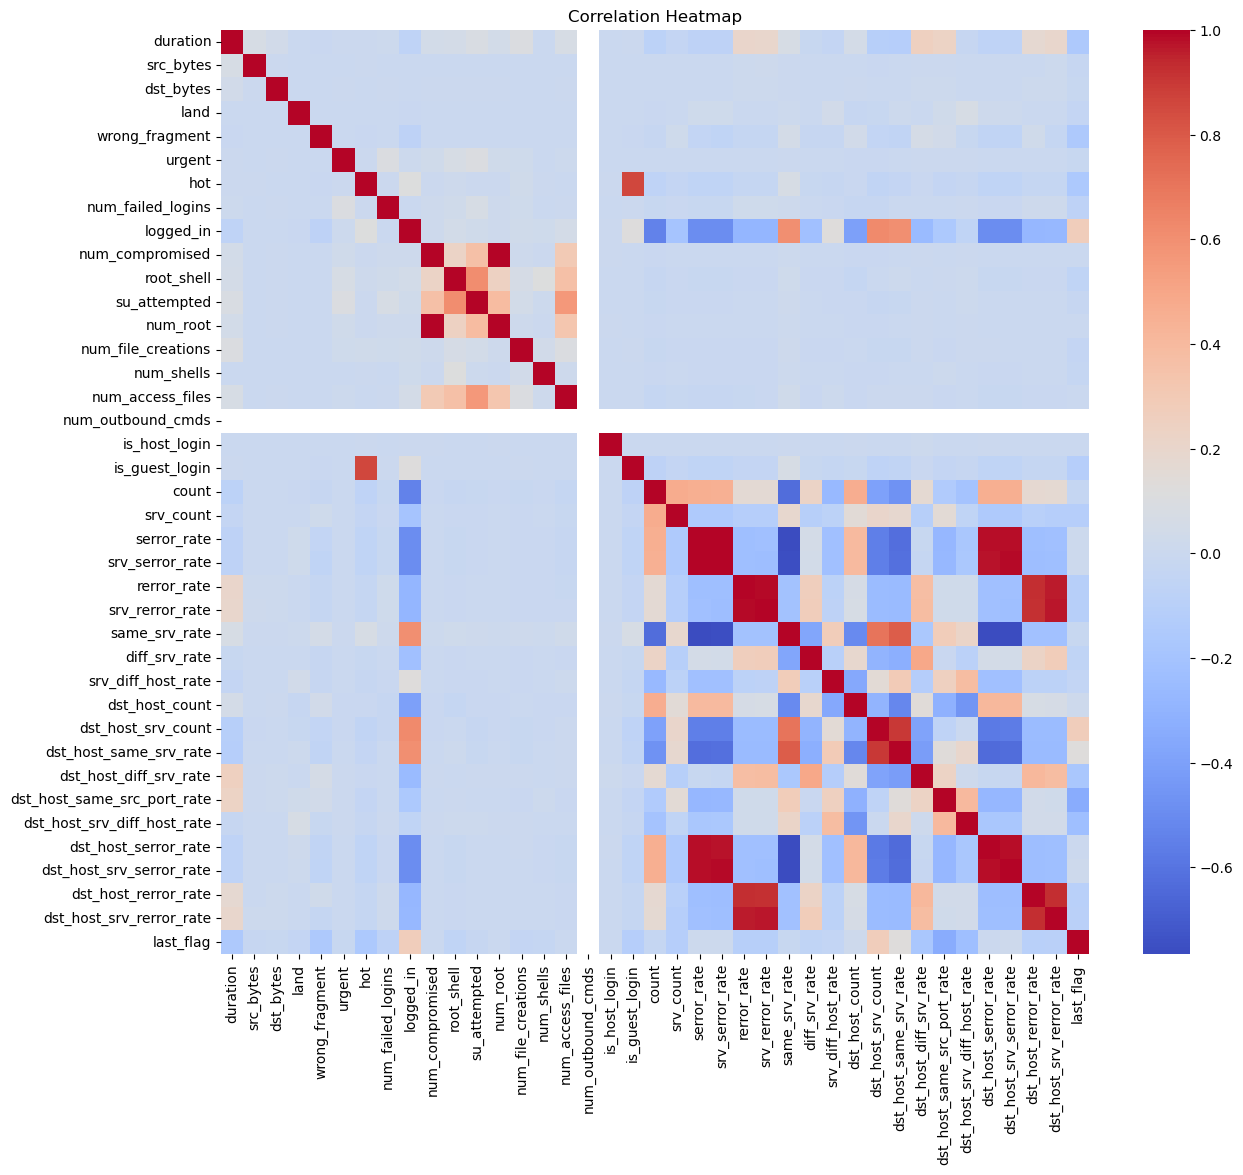

In [10]:
# Correlation Heatmap
plt.figure(figsize=(14, 12))
corr = train.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

### Data Preprocessing and Cleaning

In [11]:
## Check for missing values in both train and test datasets
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
print("Missing values in training data:\n", missing_values_train)
print("----------------------------------------------")
print("Missing values in test data:\n", missing_values_test)

Missing values in training data:
 duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_

#### Encoding categorical variables


In [12]:
categorical_cols = ['protocol_type', 'service', 'flag']
label_encoder = LabelEncoder()
for col in categorical_cols:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.transform(test[col])

# Handle the 'attack' feature by encoding it into numerical format
train['attack'] = np.where(train['attack'] == 'normal', 0, 1)
test['attack'] = np.where(test['attack'] == 'normal', 0, 1)

train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,2,44,9,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,0,15
1,0,1,49,5,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,1,19
2,0,1,24,9,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,0,21
3,0,1,24,9,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0,21
4,0,1,49,1,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,1,21


#### Feature Scaling

In [13]:
# Copy the original dataframe to keep the original values for comparison
train_original = train.copy()

# Identifying Numerical Columns
numerical_cols = [col for col in train.columns if col not in ['attack'] + categorical_cols]
scaler = StandardScaler().fit(train[numerical_cols])  # Fit only on train data

# Calculating means and standard deviations for scaling
means = train[numerical_cols].mean()
stds = train[numerical_cols].std()

# Manual Scaling
train[numerical_cols] = (train[numerical_cols] - means) / stds
test[numerical_cols] = (test[numerical_cols] - means) / stds
train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,-0.110249,2,44,9,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.161030,2.736829,2.367719,-0.289103,-0.639533,-0.624872,-0.387633,-0.376387,0,-1.965539
1,-0.110249,1,49,5,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938288,-0.174418,-0.480192,-0.289103,1.608744,1.618940,-0.387633,-0.376387,1,-0.219967
2,-0.110249,1,24,9,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066389,-0.439077,-0.383105,0.066249,-0.572085,-0.602434,-0.387633,-0.345084,0,0.652820
3,-0.110249,1,24,9,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066389,-0.439077,-0.480192,-0.289103,-0.639533,-0.624872,-0.387633,-0.376387,0,0.652820
4,-0.110249,1,49,1,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.005111,-0.068555,-0.480192,-0.289103,-0.639533,-0.624872,2.874386,2.753890,1,0.652820


In [14]:
train = train.drop(columns=['num_outbound_cmds'])
test = test.drop(columns=['num_outbound_cmds'])
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  float64
 1   protocol_type                125972 non-null  int32  
 2   service                      125972 non-null  int32  
 3   flag                         125972 non-null  int32  
 4   src_bytes                    125972 non-null  float64
 5   dst_bytes                    125972 non-null  float64
 6   land                         125972 non-null  float64
 7   wrong_fragment               125972 non-null  float64
 8   urgent                       125972 non-null  float64
 9   hot                          125972 non-null  float64
 10  num_failed_logins            125972 non-null  float64
 11  logged_in                    125972 non-null  float64
 12  num_compromised              125972 non-null  float64
 13 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,-0.110249,2,44,9,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.161030,2.736829,2.367719,-0.289103,-0.639533,-0.624872,-0.387633,-0.376387,0,-1.965539
1,-0.110249,1,49,5,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938288,-0.174418,-0.480192,-0.289103,1.608744,1.618940,-0.387633,-0.376387,1,-0.219967
2,-0.110249,1,24,9,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066389,-0.439077,-0.383105,0.066249,-0.572085,-0.602434,-0.387633,-0.345084,0,0.652820
3,-0.110249,1,24,9,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066389,-0.439077,-0.480192,-0.289103,-0.639533,-0.624872,-0.387633,-0.376387,0,0.652820
4,-0.110249,1,49,1,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.005111,-0.068555,-0.480192,-0.289103,-0.639533,-0.624872,2.874386,2.753890,1,0.652820


C:\Users\EL MOUADDIBE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\EL MOUADDIBE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


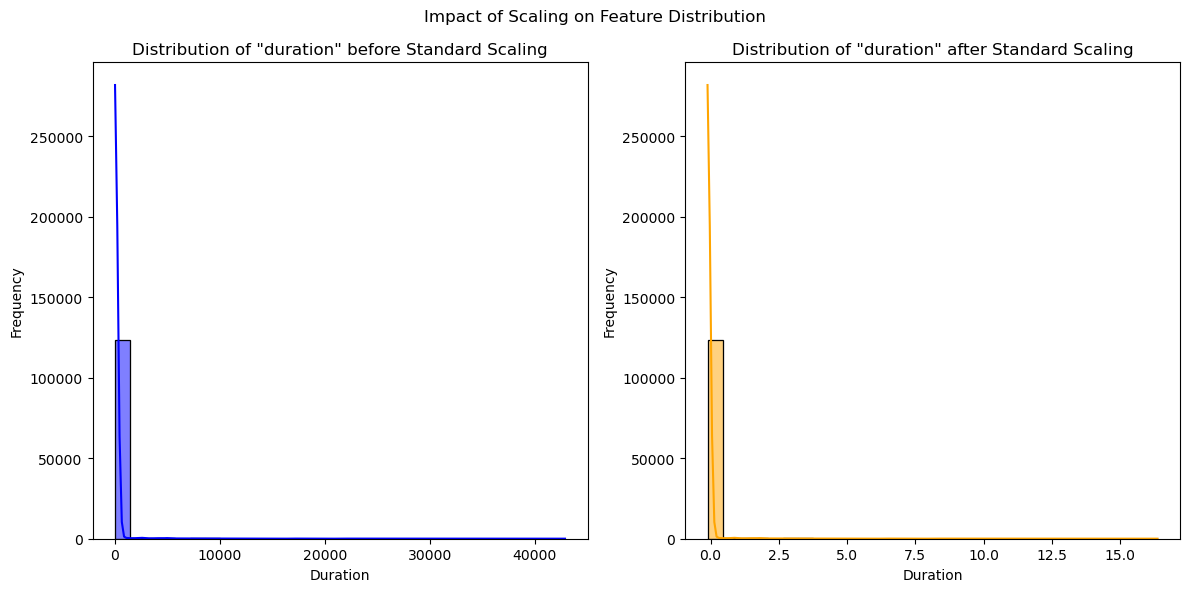

In [15]:
# Plotting
feature = 'duration'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_original[feature], bins=30, color='blue', kde=True)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of "duration" before Standard Scaling')  # Optional

plt.subplot(1, 2, 2)
sns.histplot(train[feature], bins=30, color='orange', kde=True)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title('Distribution of "duration" after Standard Scaling')  # Optional

plt.suptitle('Impact of Scaling on Feature Distribution')  # Optional main title
plt.tight_layout()
plt.show()

### Feature Engineering and Selection

Index(['same_srv_rate', 'logged_in', 'dst_host_srv_count',
       'dst_host_srv_serror_rate', 'flag', 'dst_host_same_srv_rate',
       'dst_host_serror_rate', 'last_flag', 'protocol_type', 'serror_rate',
       'dst_host_same_src_port_rate'],
      dtype='object')


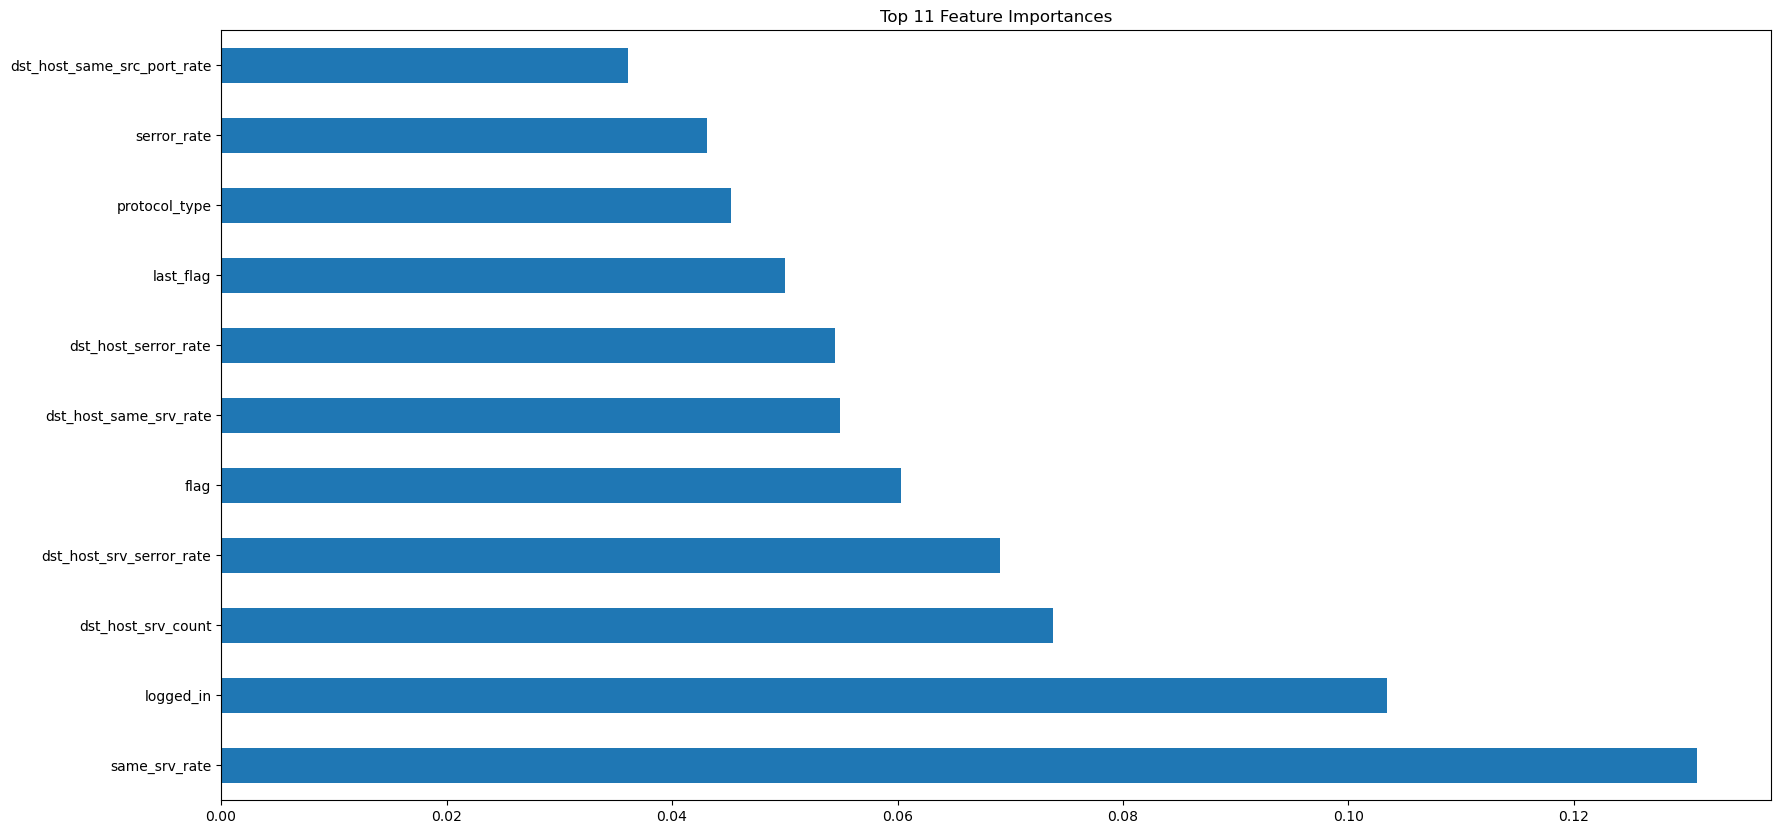

[0 1]


In [16]:
# Using ExtraTreesClassifier for Feature Selection
model = ExtraTreesClassifier(n_estimators=100)
X_train = train.drop('attack', axis=1)  # Dropping the 'attack' column for feature selection
y_train = train['attack']
model.fit(X_train, y_train)

# Plotting Feature Importances
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = feat_importances.nlargest(11).index
print(top_features)
plt.figure(figsize=(20, 10))
feat_importances.nlargest(11).plot(kind='barh')
plt.title('Top 11 Feature Importances')
plt.show()
print(y_train.unique())


In [17]:
# Keeping top 15 features plus the target variable for both train and test datasets
train = train[top_features.tolist() + ['attack']]
test = test[top_features.tolist() + ['attack']]
train.head()

,same_srv_rate,logged_in,dst_host_srv_count,dst_host_srv_serror_rate,flag,dst_host_same_srv_rate,dst_host_serror_rate,last_flag,protocol_type,serror_rate,dst_host_same_src_port_rate,attack
0,-1.321415,-0.809264,-1.035689,-0.624872,9,-1.161030,-0.639533,-1.965539,2,-0.637210,2.367719,0
1,-1.389655,-0.809264,-0.809859,1.618940,5,-0.938288,1.608744,-0.219967,1,1.602649,-0.480192,1
2,0.771285,1.235681,1.258741,-0.602434,9,1.066389,-0.572085,0.652820,1,-0.189238,-0.383105,0
3,0.771285,1.235681,1.258741,-0.624872,9,1.066389,-0.639533,0.652820,1,-0.637210,-0.480192,0
4,-1.139441,-0.809264,-0.873091,-0.624872,1,-1.005111,-0.639533,0.652820,1,-0.637210,-0.480192,1


In [18]:

X_test = test[top_features.tolist()].values
y_test = test.attack.values
X_train = train[top_features.tolist()].values
y_train = train.attack.values
print(y_train)

[0 1 0 ... 0 1 0]


### Model Building

In [ ]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, penalty='l2', C=0.01),  # Adjust C for the strength of regularization
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC()
}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.5f}")
    # Save each model to a file
    model_path = os.path.join(joblib_dir, f'{name.replace(" ", "_")}_model.joblib')
    dump(model, model_path)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

Logistic Regression Accuracy: 0.87278
Random Forest Accuracy: 0.85765
Naive Bayes Accuracy: 0.80894
KNN Accuracy: 0.87300


### Model Evaluation

In [ ]:
# Best Model Selection
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with accuracy {results[best_model_name]}")

In [ ]:
# Confusion Matrix of the best model
y_pred = best_model.predict(X_test)  # Ensure X_test is your holdout test set
conf_mat = confusion_matrix(y_test, y_pred)  # Ensure y_test is your holdout test set
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### VotingClasifier

In [ ]:
from sklearn.ensemble import VotingClassifier

# Définir les modèles
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, penalty='l2', C=0.01)),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("Naive Bayes", GaussianNB()),
    ("KNN", KNeighborsClassifier()),
    ("SVC", SVC())
]

# Créer un VotingClassifier avec vote majoritaire
voting_clf = VotingClassifier(estimators=models, voting='hard')

# Entraîner le VotingClassifier sur les données d'entraînement
voting_clf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred_voting = voting_clf.predict(X_test)

# Calculer l'accuracy du VotingClassifier
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy_voting:.5f}")


In [ ]:
from sklearn.ensemble import VotingClassifier

# Définir les modèles
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, penalty='l2', C=0.01)),
    ("KNN", KNeighborsClassifier()),
    ("SVC", SVC())
]

# Créer un VotingClassifier avec vote majoritaire
voting_clf = VotingClassifier(estimators=models, voting='hard')

# Entraîner le VotingClassifier sur les données d'entraînement
voting_clf.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred_voting = voting_clf.predict(X_test)

# Calculer l'accuracy du VotingClassifier
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {accuracy_voting:.5f}")
